In [9]:
import numpy as np
z = np.array([1, 2, 3, 4, 5, 1, 2])

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

softmax(z)  

array([0.01117202, 0.03036871, 0.0825507 , 0.22439607, 0.60997177,
       0.01117202, 0.03036871])

Tải và chuẩn bị CIFAR-10 bằng torchvision

In [10]:
import torchvision
import torchvision.transforms as transforms

# Biến đổi dữ liệu (chuẩn hóa pixel về giá trị trong khoảng [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu huấn luyện và kiểm tra
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Tạo DataLoader để dễ dàng lặp qua dữ liệu
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
from tensorflow.keras.losses import CategoricalCrossentropy


Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7647059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.6313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.24705887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.9843137].
Clippi

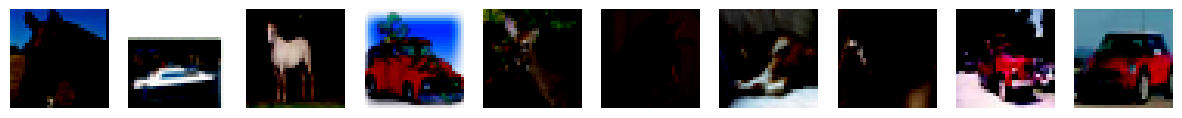

In [ ]:
# Lấy một batch đầu tiên từ trainloader
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Hiển thị 10 hình ảnh đầu tiên từ batch
import matplotlib.pyplot as plt
import numpy as np

# Chuyển hình ảnh từ tensor sang numpy
images = images.numpy()

# Hiển thị hình ảnh
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    ax = axes[i]
    ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Chuyển kênh từ (C, H, W) sang (H, W, C)
    ax.axis('off')
plt.show()


In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np

# 1. Tải và chuẩn bị dữ liệu CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),  # Chuyển đổi ảnh thành tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa pixel
])

# Tải tập dữ liệu huấn luyện và kiểm tra
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Tạo DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# 2. Định nghĩa mô hình
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)  # Lớp fully connected

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Chuyển đổi tensor thành dạng vector (flatten)
        z = self.fc(x)  # Tính toán đầu ra của mô hình (logits)
        return z

# Hàm Softmax thủ công
def softmax(z):
    e_z = torch.exp(z - torch.max(z, dim=1, keepdim=True).values)  # Để tránh tràn số học (overflow)
    return e_z / torch.sum(e_z, dim=1, keepdim=True)

# Khởi tạo mô hình
input_size = 3 * 32 * 32  # CIFAR-10 có kích thước ảnh 32x32x3
num_classes = 10  # 10 lớp
model = SoftmaxClassifier(input_size, num_classes)

# 3. Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()  # Hàm mất mát Cross-Entropy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Tối ưu hóa SGD

# 4. Huấn luyện mô hình
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Đặt gradient về 0
        optimizer.zero_grad()
        
        # Lan truyền tiến (forward)
        logits = model(inputs)
        
        # Tính toán softmax thủ công
        probabilities = softmax(logits)
        
        # Tính toán mất mát bằng CrossEntropy (dùng softmax bên trong)
        loss = criterion(logits, labels)
        
        # Lan truyền ngược (backward) và tối ưu hóa
        loss.backward()
        optimizer.step()
        
        # Thống kê mất mát
        running_loss += loss.item()
        if i % 100 == 99:  # Mỗi 100 batch
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Huấn luyện hoàn tất!")

# 5. Đánh giá mô hình
correct = 0
total = 0
with torch.no_grad():  # Không tính gradient khi đánh giá
    for inputs, labels in testloader:
        logits = model(inputs)
        
        # Tính toán softmax thủ công
        probabilities = softmax(logits)
        
        # Dự đoán nhãn từ softmax (lấy lớp có xác suất cao nhất)
        _, predicted = torch.max(probabilities, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Độ chính xác trên tập kiểm tra: {100 * correct / total:.2f}%")


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 